In [364]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training2/sample_submission.csv
/kaggle/input/training2/train.csv
/kaggle/input/training2/test.csv


### Explorative Data Analysis

In [365]:
pd.options.display.max_columns = 100

In [366]:
sample = pd.read_csv('/kaggle/input/training2/sample_submission.csv', sep=";")
test = pd.read_csv('/kaggle/input/training2/test.csv')
train = pd.read_csv('/kaggle/input/training2/train.csv')

In [367]:
type(sample)

pandas.core.frame.DataFrame

In [368]:
sample.head()

,"id,stroke"
0,"37061,0.5"
1,"42333,0.5"
2,"58964,0.5"
3,"34063,0.5"
4,"43682,0.5"


In [369]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [370]:
train['avg_glucose_level'].head()

0     95.12
1     87.96
2    110.89
3     69.04
4    161.28
Name: avg_glucose_level, dtype: float64

In [371]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [372]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 12 columns):
id                   30001 non-null int64
gender               30001 non-null object
age                  30001 non-null float64
hypertension         30001 non-null int64
heart_disease        30001 non-null int64
ever_married         30001 non-null object
work_type            30001 non-null object
Residence_type       30001 non-null object
avg_glucose_level    30001 non-null float64
bmi                  28984 non-null float64
smoking_status       20825 non-null object
stroke               30001 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.7+ MB


In [373]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,28984.000000,30001.000000
mean,36379.812206,42.276327,0.09453,0.047832,104.598059,28.661727,0.017666
std,21066.978944,22.456670,0.29257,0.213414,43.251126,7.780740,0.131737
min,1.000000,0.080000,0.00000,0.000000,55.000000,10.100000,0.000000
25%,18012.000000,24.000000,0.00000,0.000000,77.500000,23.300000,0.000000
50%,36509.000000,44.000000,0.00000,0.000000,91.590000,27.800000,0.000000
75%,54546.000000,60.000000,0.00000,0.000000,112.160000,33.000000,0.000000
max,72943.000000,82.000000,1.00000,1.000000,281.590000,97.600000,1.000000


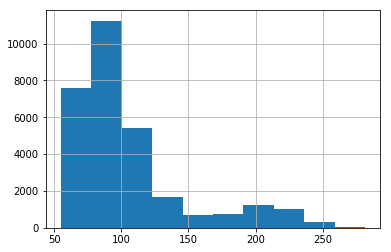

In [374]:
train['avg_glucose_level'].hist()

<Figure size 864x576 with 0 Axes>

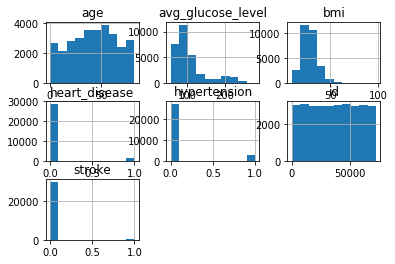

In [375]:
plt.figure(figsize=(12, 8))
train.hist();

In [376]:
#indexing
train[train['bmi'] > 65]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
302,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
692,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
1334,37759,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,NaN,0
1913,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,NaN,0
4026,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
5391,41594,Male,38.0,0,0,Yes,Private,Urban,62.29,69.8,smokes,0
6340,17812,Male,18.0,0,0,No,Govt_job,Urban,104.89,89.1,NaN,0
7046,13110,Female,38.0,0,0,Yes,Self-employed,Urban,204.28,66.3,smokes,0
8070,33294,Female,67.0,1,0,Yes,Govt_job,Rural,85.44,68.6,formerly smoked,0
10322,64521,Male,6.0,0,0,No,children,Urban,58.33,96.1,NaN,0


In [377]:
train[(train['age'] > 65) & (train['stroke'] == 0)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
9,28674,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0
10,10460,Female,79.0,0,0,Yes,Govt_job,Urban,77.08,35.0,NaN,0
11,64908,Male,79.0,0,1,Yes,Private,Urban,57.08,22.0,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29965,47447,Male,70.0,0,0,Yes,Self-employed,Rural,56.53,30.9,NaN,0
29967,24214,Female,67.0,1,1,No,Self-employed,Rural,91.01,36.8,never smoked,0
29968,11556,Female,80.0,0,1,Yes,Private,Rural,92.38,23.9,NaN,0
29973,64163,Female,81.0,0,0,Yes,Self-employed,Rural,135.53,19.0,never smoked,0


In [378]:
train.loc[train['stroke'] == 1, 'bmi'].median()

29.35

In [379]:
train.loc[train['stroke'] == 0, 'bmi'].median()

27.8

In [380]:
#grouping
for (stroke, subdata) in train.groupby('stroke'):
    print('Median BMI for {} is {}'.format('people with stroke' if stroke == 1 else 'people without stroke',
                                           subdata['bmi'].median()))

Median BMI for people without stroke is 27.8
Median BMI for people with stroke is 29.35


In [381]:
train.groupby(['gender', 'stroke'])['bmi'].median()

gender  stroke
Female  0         27.5
        1         28.4
Male    0         28.1
        1         30.4
Other   0         32.1
Name: bmi, dtype: float64

In [382]:
#crosstab
pd.crosstab(train['gender'], train['stroke'])

stroke,0,1
gender,,
Female,17383,293
Male,12078,237
Other,10,0


### Visualisation

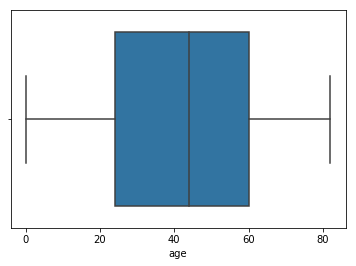

In [383]:
sns.boxplot(x='age', data=train)

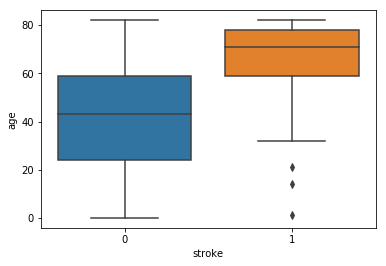

In [384]:
sns.boxplot(x='stroke', y='age', data=train)

### Visualisation of whole dataset

In [385]:
train.corr()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.013442,0.009823,0.006829,0.022125,0.017689,0.007366
age,0.013442,1.000000,0.274369,0.252770,0.234806,0.355840,0.152684
hypertension,0.009823,0.274369,1.000000,0.121906,0.161272,0.161511,0.073425
heart_disease,0.006829,0.252770,0.121906,1.000000,0.149709,0.060918,0.101548
avg_glucose_level,0.022125,0.234806,0.161272,0.149709,1.000000,0.188645,0.087426
bmi,0.017689,0.355840,0.161511,0.060918,0.188645,1.000000,0.020317
stroke,0.007366,0.152684,0.073425,0.101548,0.087426,0.020317,1.000000


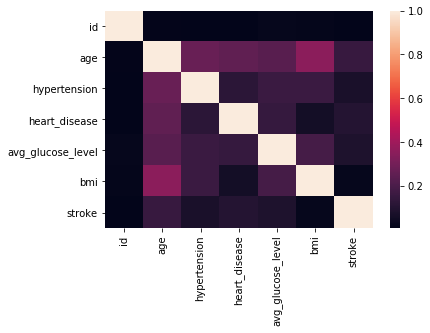

In [386]:
sns.heatmap(train.corr());

### Numeric

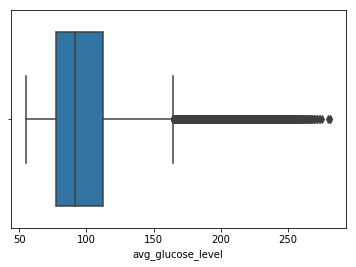

In [387]:
sns.boxplot(x = 'avg_glucose_level', data = train)

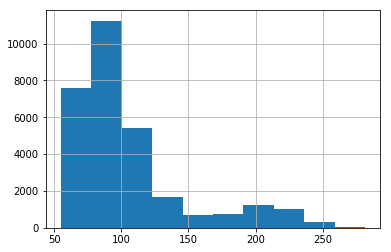

In [388]:
train['avg_glucose_level'].hist();

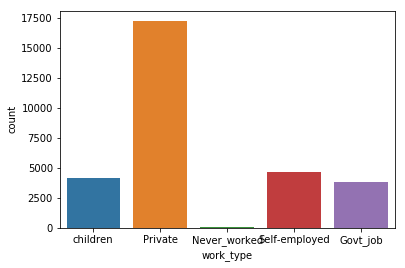

In [389]:
sns.countplot(x='work_type', data = train);

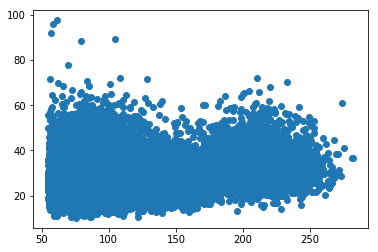

In [390]:
plt.scatter(train['avg_glucose_level'], train['bmi']);

In [391]:
train.corrwith(train['bmi'])

id                   0.017689
age                  0.355840
hypertension         0.161511
heart_disease        0.060918
avg_glucose_level    0.188645
bmi                  1.000000
stroke               0.020317
dtype: float64

In [392]:
pd.crosstab(train['gender'], train['work_type'])

work_type,Govt_job,Never_worked,Private,Self-employed,children
gender,,,,,
Female,2319,64,10514,2780,1999
Male,1483,51,6699,1894,2188
Other,2,0,7,0,1


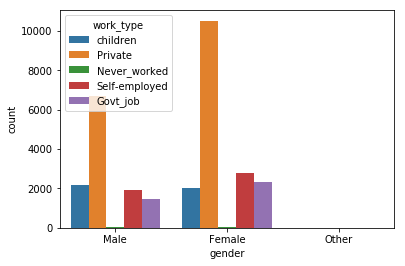

In [393]:
sns.countplot(x='gender', hue = 'work_type', data = train);

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


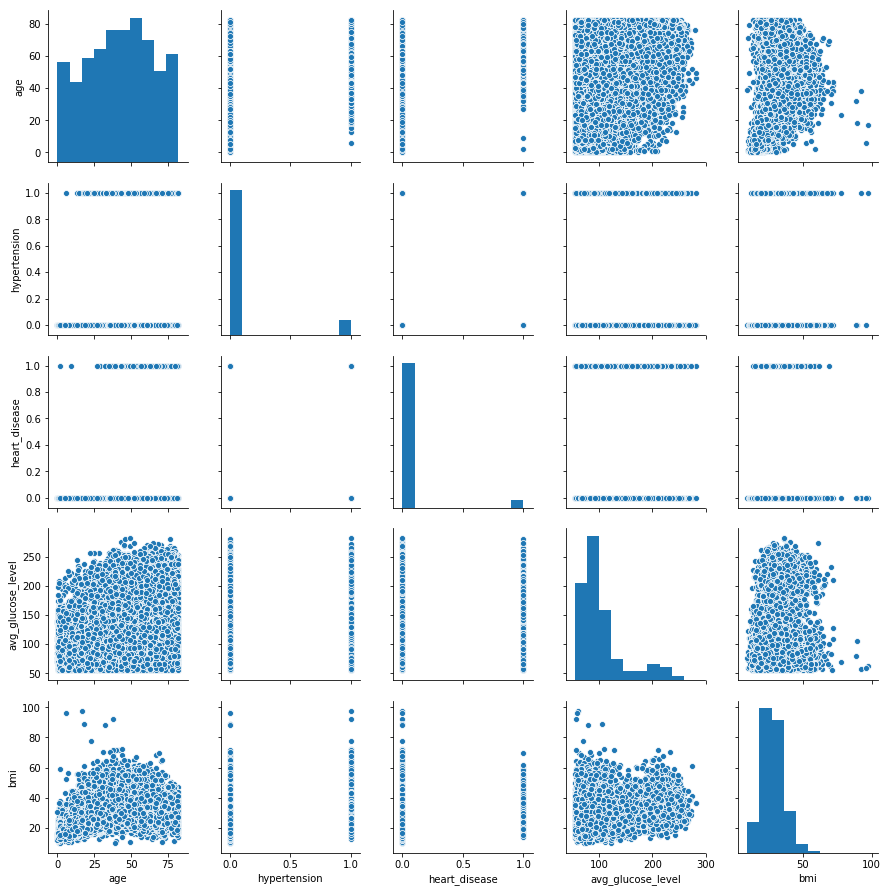

In [394]:
#scatter plots of features
numeric = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
sns.pairplot(train[numeric])

### Selecting features

In [395]:

#get rid of nan
for col in numeric:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())


In [396]:
categoric = list(set(train.columns.values.tolist()) - set(numeric + ['id', 'stroke']))

In [397]:
for col in categoric:
    train[col] = train[col].fillna('nan')
    test[col] = test[col].fillna('nan')

In [398]:
# converting categorical to numerical

ever_married_num = {'No' : 0, 'Yes' : 1}

train['ever_married'] = train['ever_married'].replace(ever_married_num)
test['ever_married'] = test['ever_married'].replace(ever_married_num)

In [399]:
Residence_type_num = {'Rural' : 0, 'Urban' : 1}

train['Residence_type'] = train['Residence_type'].replace(Residence_type_num)
test['Residence_type'] = test['Residence_type'].replace(Residence_type_num)

In [400]:
gender_num = {'Other' : 0, 'Male' : 0, 'Female' : 1}

train['gender'] =train['gender'].replace(gender_num)
test['gender'] = test['gender'].replace(gender_num)

In [401]:
train_num = pd.get_dummies(train)
test_num = pd.get_dummies(test)

### Algorithms

In [402]:
# Cross-validation

def cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return scores

In [403]:
y = train_num.stroke
train_num = train_num.drop(columns='stroke')

In [422]:
alg1 = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=1)
cv1 = cross_validation_for_roc_auc(alg1, train_num, y) 
print(cv1)
print(np.mean(cv1))
sample.to_csv('submit1.csv', index=None)

[0.8446922631944658, 0.8539927055936651, 0.855810149898374, 0.8571840618865607, 0.8480309142560798]
0.8519420189658291


In [423]:
all_features = train.columns
features = {}
for f in all_features:
    cv1 = cross_validation_for_roc_auc(alg1, train_num[[f]] , y)
    print(f,  np.mean(cv1))
    features[f] = np.mean(cv1)

id 0.5014835165729895
gender 0.5179829747672076
age 0.8319167070632064
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761


KeyError: "None of [Index(['work_type'], dtype='object')] are in the [columns]"

In [424]:
features_selected=['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level']
scores_01_fs = cross_validation_for_roc_auc(alg1, train_num[features_selected] , y)
print(scores_01_fs)
print(np.mean(scores_01_fs))

[0.8386345666081348, 0.8459816146049255, 0.8425970034439928, 0.8497041657501823, 0.8348019440734672]
0.8423438588961405


In [426]:
depths = [5,6,7,8]
ns = [150,180, 220,250,300]
hyperparameters = pd.DataFrame(columns=depths, index=ns)
for d in depths:
    for n in ns:
        alg1_hs = GradientBoostingClassifier(n_estimators=n, max_depth=d, random_state=1)
        cv2_hs = cross_validation_for_roc_auc(alg1_hs, train_num[features_selected] , y)
        hyperparameters.loc[n,d]=np.mean(cv2_hs)
        print(d, n, np.mean(cv2_hs))

5 150 0.8251418282436342
5 180 0.8246257274708336
5 220 0.8229313504983475
5 250 0.8213236388858547
5 300 0.819175087303277
6 150 0.8232295305145284
6 180 0.8211461026468898
6 220 0.8205902221479132
6 250 0.8196515306060604
6 300 0.8181300701817777
7 150 0.824636429242382
7 180 0.8232892576711096
7 220 0.8192745770306846
7 250 0.8177699327953439


KeyboardInterrupt: 

In [427]:
alg1_final = GradientBoostingClassifier(n_estimators=150, max_depth=5, random_state=1)
alg1_final.fit(train_num[features_selected], y)
prediction = alg1_final.predict_proba(test_num[features_selected])[:,1]
sample.stroke = prediction
sample.to_csv('submit1_1.csv', index=None)

NameError: name 'train_' is not defined

In [405]:
alg2 = LogisticRegression(max_iter=1000,random_state=1, solver = 'lbfgs')
cv2 = cross_validation_for_roc_auc(alg2, train_num, y)
print(cv2)
print(np.mean(cv2))

[0.8388442199014887, 0.7223778489054195, 0.6741298272357724, 0.6771194307144704, 0.6576576576576576]
0.7140257968829617


In [406]:
# Boosting
alg3 = LGBMClassifier(n_estimators=100, max_depth=5, random_state=1)
cv3 = cross_validation_for_roc_auc(alg1, train_num, y)
print(cv3)
print(np.mean(cv3))

[0.8430210269417318, 0.8477775222852002, 0.8563835605803974, 0.8505314226189735, 0.8466280850386811]
0.8488683234929967
